In [2]:
import json
import os
from collections import Counter
from itertools import combinations
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [35]:
data = json.load(open('train.json'))

In [36]:
c = Counter([len(data[k]) for k in data])

In [37]:
c

Counter({700: 64})

Посмотрим, как все работает в тетрадочном коде.

In [38]:
ent1 = []
ent2 = []
left = []
right = []
middle = []
sents = []
target = []
for key in data:
    for instance in data[key]:
        
        tokens = instance['tokens']
        sents.append(tokens)
        
        ent1.append(' '.join([tokens[i] for i in instance['h'][2][0]]))
        ent2.append(' '.join([tokens[i] for i in instance['t'][2][0]]))

        if instance['h'][2][0][0] < instance['t'][2][0][0]:
            first, second = 'h', 't'
        else:
            second, first = 'h', 't'

        first_start = instance[first][2][0][0]
        first_end = instance[first][2][0][-1]
        second_start = instance[second][2][0][0]
        second_end = instance[second][2][0][-1]

        left_context = tokens[max(0, first_start-3):first_start]
        left.append((['<START>']*(3-len(left_context))) + left_context)

        right_context = tokens[second_end+1:second_end+4]
        right.append(right_context + (['<END>']*(3-len(right_context))))

        middle_context = tokens[first_end+1:second_start]
        middle.append(middle_context)

        target.append(key)

In [47]:
lefts_s = [' '.join(l) for l in left]
rights_s = [' '.join(l) for l in right]
middles_s = [' '.join(l) for l in middle]

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
tfidf.fit(lefts_s + rights_s + middles_s)

l = tfidf.fit_transform(lefts_s)
r = tfidf.fit_transform(rights_s)
m = tfidf.fit_transform(middles_s)

X = csr_matrix(hstack([l,m,r]))

In [8]:
y = np.array(target)

In [9]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    clf = LogisticRegression()
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)
print(metrics_micro/N)
print(metrics_macro/N)

[0.47310268 0.47310268 0.47310268]
[0.4700454  0.47310268 0.46596267]


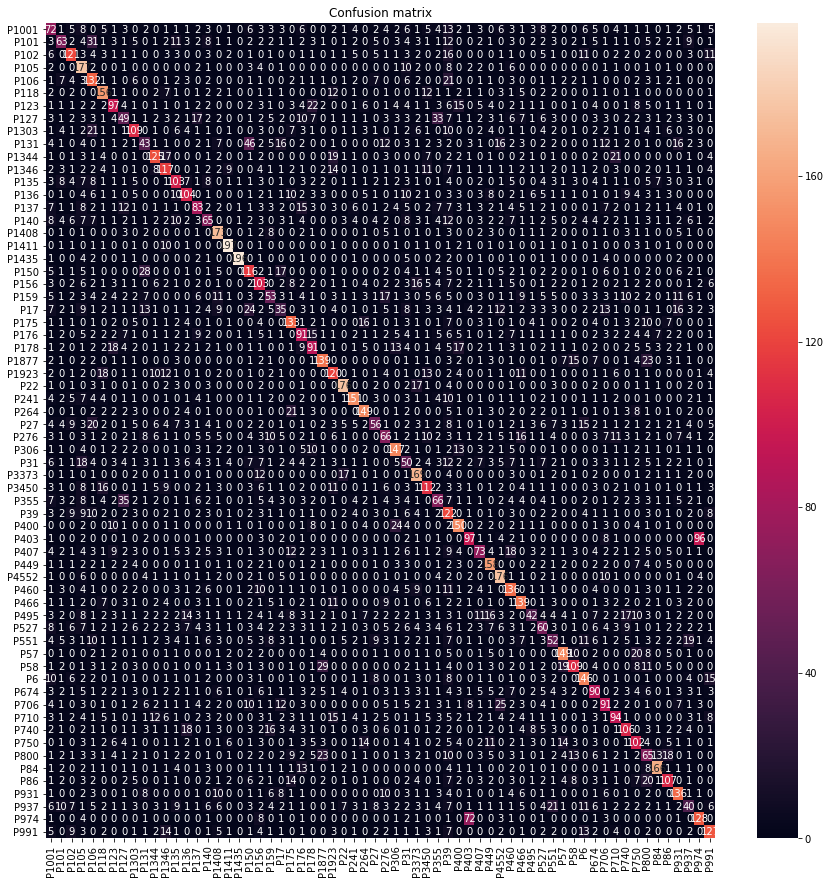

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=np.round(conf/3).astype(int), 
            annot=True, 
            fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax)
plt.title("Confusion matrix")
plt.show()

Запомним качество и сравним с вордтувековским классификатором (склад этих моделей подсказала Маша Федорова).

In [11]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

In [21]:
model = api.load("glove-wiki-gigaword-50")  # download the model and return as object ready for use

Воспользуемся тетрадкой 4 семинара и соберем эмбеддинги.

In [48]:
def get_embedding(text, model, dim):
    text = text.split()
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector

In [49]:
dim = 50
l = np.zeros((len(lefts_s), dim))
m = np.zeros((len(middles_s), dim))
r = np.zeros((len(rights_s), dim))

In [50]:
for i, text in enumerate(lefts_s):
    l[i] = get_embedding(text, model, dim)
    
for i, text in enumerate(middles_s):
    m[i] = get_embedding(text, model, dim)

for i, text in enumerate(rights_s):
    r[i] = get_embedding(text, model, dim)

In [51]:
X_text_w2v = np.concatenate([l, m, r], axis=1)

In [52]:
X_text_w2v.shape

(44800, 150)

In [53]:
y = np.array(target)

In [54]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    clf = LogisticRegression()
    clf.fit(X_text_w2v[train_index], y[train_index])
    preds = clf.predict(X_text_w2v[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)
print(metrics_micro/N)
print(metrics_macro/N)

[0.33294643 0.33294643 0.33294643]
[0.33495113 0.33294643 0.3206039 ]


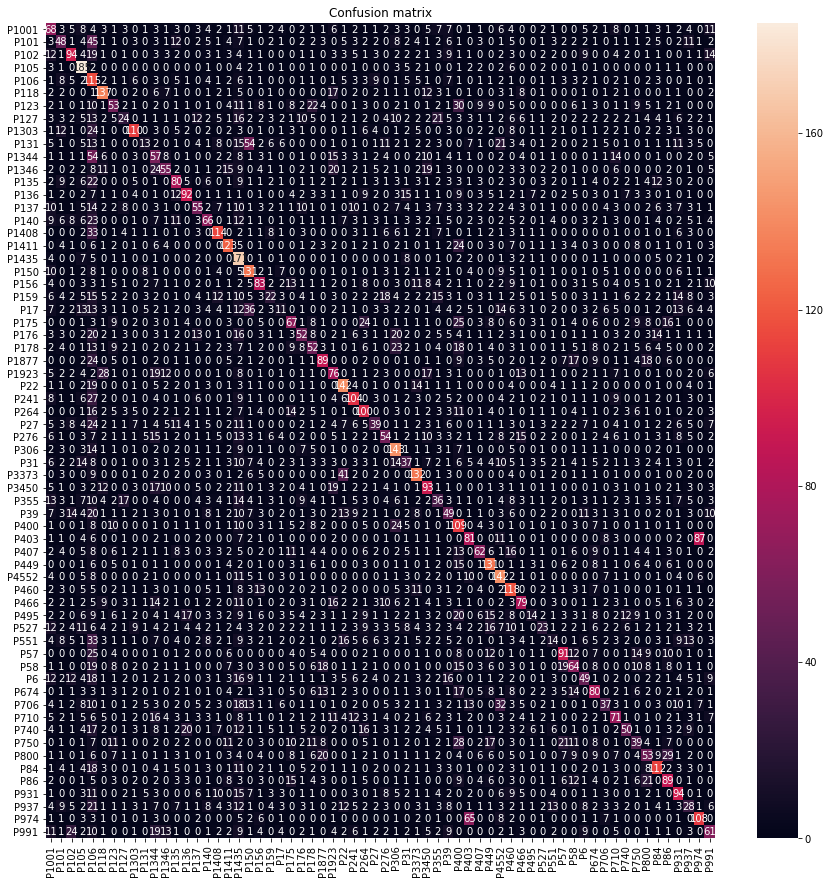

In [55]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=np.round(conf/3).astype(int), 
            annot=True, 
            fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax)
plt.title("Confusion matrix")
plt.show()

Часто путаются p403 и p974.

In [57]:
print(data['P403'][0])
print(data['P974'][0])

{'tokens': ['The', 'Peel', 'watershed', 'drains', '14', '%', 'of', 'the', 'Yukon', 'Territory', 'Canada', 'and', 'flows', 'into', 'the', 'Beaufort', 'Sea', 'via', 'the', 'Peel', 'and', 'then', 'Mackenzie', 'Rivers', '.'], 'h': ['mackenzie', 'Q3411', [[22]]], 't': ['beaufort sea', 'Q131274', [[15, 16]]]}
{'tokens': ['The', 'east', 'side', 'of', 'Grace', 'Peak', 'drains', 'into', 'Lindsay', 'Brook', ',', 'thence', 'into', 'the', 'Schroon', 'River', ',', 'the', 'Hudson', 'River', ',', 'and', 'into', 'New', 'York', 'Bay', '.'], 'h': ['hudson river', 'Q3140', [[18, 19]]], 't': ['schroon river', 'Q7432908', [[14, 15]]]}


В обоих классах есть водоемы и слово drains в разных значениях, но их распределение в предложении похоже.

Еще часто путаются p131 и p150.

In [59]:
print(data['P131'][0])
print(data['P150'][0])

{'tokens': ['Downing', 'House', 'is', 'a', 'historic', 'home', 'located', 'at', 'Memphis', ',', 'Scotland', 'County', ',', 'Missouri', '.'], 'h': ['memphis', 'Q962034', [[8]]], 't': ['scotland county, missouri', 'Q496971', [[10, 11, 12, 13]]]}
{'tokens': ['The', 'sailor', 'was', 'rescued', 'by', 'Saudi', 'Arabian', 'border', 'guards', 'in', 'the', 'Red', 'Sea', 'and', 'taken', 'to', 'Jizan', 'Province', 'of', 'Saudi', 'Arabia', '.'], 'h': ['saudi arabia', 'Q851', [[19, 20]]], 't': ['jizan province', 'Q269973', [[16, 17]]]}


Классы путаются, возможно, из-за того, что здесь отношение "некая именованная сущность - глагол - территория", отсюда и путаница.

Качество с этой моделью только ухудшилось... Попробуем другую.

In [14]:
model = api.load("glove-twitter-25")  # download the model and return as object ready for use

In [16]:
dim = 50
for i, text in enumerate(lefts_s):
    l[i] = get_embedding(text, model, dim)
    
for i, text in enumerate(middles_s):
    m[i] = get_embedding(text, model, dim)

for i, text in enumerate(rights_s):
    r[i] = get_embedding(text, model, dim)

In [17]:
X_text_w2v = np.concatenate([l, m, r], axis=1)

In [18]:
X_text_w2v.shape

(44800, 150)

In [19]:
y = np.array(target)

In [20]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    clf = LogisticRegression()
    clf.fit(X_text_w2v[train_index], y[train_index])
    preds = clf.predict(X_text_w2v[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)
print(metrics_micro/N)
print(metrics_macro/N)

[0.015625 0.015625 0.015625]
[0.00024414 0.015625   0.00048077]


Что-то на этой модели совсем все тоскливо. Твиттер явно не подходит.   